# Data manipulations

A matrix transformation is a matrix multiplication between a transformation matrix M and a data matrix D that gives you a manipulated data matrix D' as output.

We can use matrix multiplications to transform our data (our data points, represented as feature vectors).

## Load and look at our data

Let's load the used car data.

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns

data = np.array(np.genfromtxt('data/vehiclesNumeric.csv', delimiter=',', skip_header=1, dtype=int, encoding="utf-8"))  

# get a pandas dataframe for plotting
df = pd.DataFrame(data, columns=["id", "price", "year", "odometer"])

Let's get some **summary statistics**.

In [53]:
def getSummaryStatistics(data):
    print("")
    return np.array([data.min(axis=0), data.max(axis=0), data.mean(axis=0, dtype=int)])

def getShapeType(data):
    return (data.shape, data.dtype)

print("min, max, mean for each variable\n", getSummaryStatistics(data))
print("shape\n", getShapeType(data))


min, max, mean for each variable
 [[7301645993          0       1999          0]
 [7317070740      55000       2021    9999999]
 [7311728502       7978       2012     112440]]
shape
 ((3158, 4), dtype('int64'))


Let's **reduce the data** to two dimensions, just year and price.


In [55]:
# How are we going to get just those two columns?
reducedData = data[:, [1,2]]

print("min, max, mean for each variable\n", getSummaryStatistics(reducedData))
print("shape\n", getShapeType(reducedData))


min, max, mean for each variable
 [[    0  1999]
 [55000  2021]
 [ 7978  2012]]
shape
 ((3158, 2), dtype('int64'))


Let's plot the used car data.

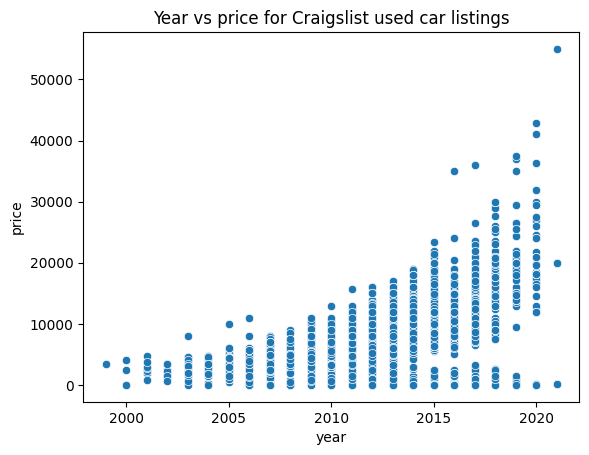

In [57]:
def plot2d(data):
    sns.scatterplot(pd.DataFrame(data[:, [0, 1]], columns=["price", "year"]), x="year", y="price").set(title="Year vs price for Craigslist used car listings")
    
plot2d(reducedData)

## Translation

Translation is a kind of data transformation where we move data around, but each data point stays the same distance away from every other data point.

Translation is a two step process:
* Add homogeneous coordinate
* Do translation as matrix multiplication

### Add homogeneous coordinate

We need to add a dummy column of ones so we can do the matrix multiplication. Why? See https://www.sciencedirect.com/topics/mathematics/homogeneous-coordinate.

homogenized data

min, max, mean for each variable
 [[    0  1999     1]
 [55000  2021     1]
 [ 7978  2012     1]]
shape
 ((3158, 3), dtype('int64'))


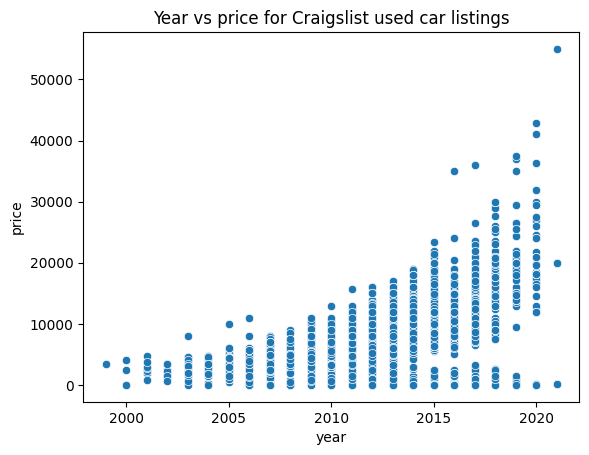

In [58]:
# How do we append a whole column?
homogenizedData = np.append(reducedData, np.array([np.ones(reducedData.shape[0], dtype=int)]).T, axis=1)
print("homogenized data")
print("min, max, mean for each variable\n", getSummaryStatistics(homogenizedData))
print("shape\n", getShapeType(homogenizedData))

plot2d(homogenizedData)

### Translate

Let's **translate** that year column so that it too starts at 0.

A translation matrix for two-variable data looks like:
$$\begin{pmatrix} 1 & 0 & x \\ 0 & 1 & y \\ 0 & 0 & 1\end{pmatrix}$$
where $x, y$ are the amount by which you want the $0th$ and $1st$ variables translated, respectively.



transformMatrix
((3, 3), dtype('float64'))
[[ 1.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  1.000e+00 -1.999e+03]
 [ 0.000e+00  0.000e+00  1.000e+00]]
after translation, translatePriceData

min, max, mean for each variable
 [[0.000e+00 0.000e+00 1.000e+00]
 [5.500e+04 2.200e+01 1.000e+00]
 [7.978e+03 1.300e+01 1.000e+00]]
shape
 ((3158, 3), dtype('float64'))


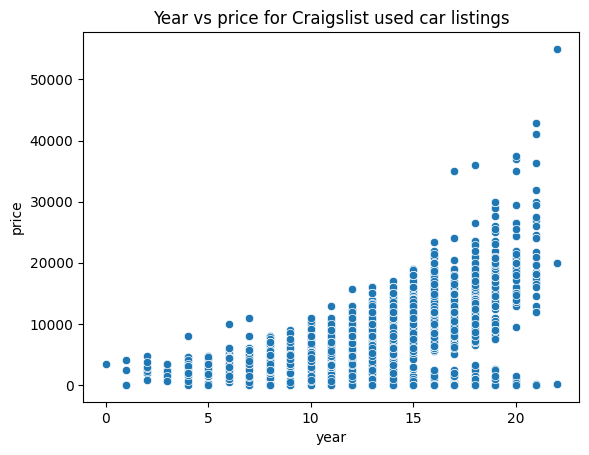

In [90]:
# we need to define a transformation matrix that will allow us to shift the price variable; this one will be the identity matrix with the translation specified in an extra last column
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
translateTransform[1, 2] = -reducedData[:, 1].min()
print("transformMatrix")
print(getShapeType(translateTransform))
print(translateTransform)

# now we need to do the translation
translatePriceData = (translateTransform@homogenizedData.T).T
print("after translation, translatePriceData")
print("min, max, mean for each variable\n", getSummaryStatistics(translatePriceData))
print("shape\n", getShapeType(translatePriceData))
plot2d(translatePriceData)

## Scaling

Scaling is kind of data transformation where we increase or decrease the range of one or more variables.

### Scaling on its own

Let's **scale** that year column so it's months instead of years.

A scaling matrix for two-variable data looks like:
$$\begin{pmatrix} x & 0 \\ 0 & y \end{pmatrix}$$
where $x, y$ are the amount by which you want the $0th$ and $1st$ variables scaled, respectively. 


transformMatrix
((2, 2), dtype('float64'))
[[ 1.  0.]
 [ 0. 12.]]
after scaling, scaleAgeData

[[    0. 23988.]
 [55000. 24252.]
 [ 7978. 24148.]]
((3158, 2), dtype('float64'))


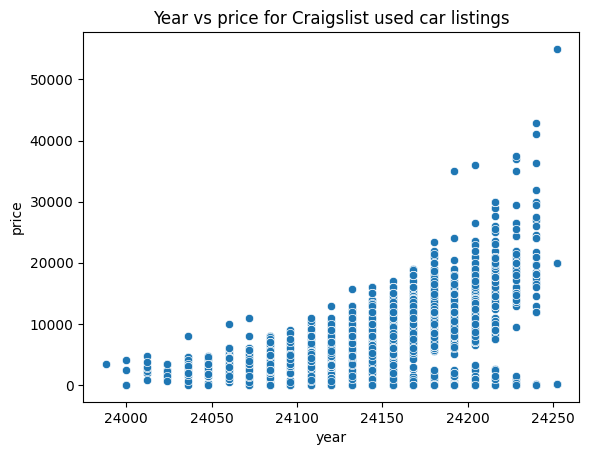

In [91]:
scaleTransform = np.eye(reducedData.shape[1], dtype=float)
scaleTransform[1, 1] = 12
print("transformMatrix")
print(getShapeType(scaleTransform))
print(scaleTransform)

scaleAgeData = (scaleTransform@reducedData.T).T
print("after scaling, scaleAgeData")
print(getSummaryStatistics(scaleAgeData))
print(getShapeType(scaleAgeData))
plot2d(scaleAgeData)

## Global max-min normalization

Let's try **global (max-min) normalization**

Okay, so here is how that works:
1. subtract the global minimum from each datapoint
2. divide by the global range (max - min)

The transformation matrix for two variables looks like:
$$\begin{pmatrix} \frac{1}{(max(data)-min(data))} & 0 & -min(data) \\ 0 & \frac{1}{(max(data)-min(data))} & -min(data) \\ 0 & 0 & 1\end{pmatrix}$$


What is the effect on the data?

What does that look like from the perspective of operations we have learned so far?

In [92]:
# subtract the global minimum from each datapoint
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(reducedData.shape[1]):
    translateTransform[i, 2] = -reducedData.min()
print("transformMatrix")
print(translateTransform)

# divide by the global range
scaleTransform = np.eye(3, 3)
scaleTransform[0, 0] = 1 / (reducedData.max() - reducedData.min())
scaleTransform[1, 1] = 1 / (reducedData.max() - reducedData.min())
scaleTransform[2, 2] = 1 / (reducedData.max() - reducedData.min())
print("transformMatrix")
print(getShapeType(scaleTransform))
print(scaleTransform)

# when we do a series of transformations, first we multiply the smaller transformation matrices, and only at the end the result of that with the larger data matrix (more efficient!)
totalTransform = scaleTransform@translateTransform
print("transformMatrix")
print(getShapeType(totalTransform))
print(totalTransform)


transformMatrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
transformMatrix
((3, 3), dtype('float64'))
[[1.81818182e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81818182e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81818182e-05]]
transformMatrix
((3, 3), dtype('float64'))
[[1.81818182e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81818182e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81818182e-05]]


after global normalization, globalNormalizedData

[[0.00000000e+00 3.63454545e-02 1.81818182e-05]
 [1.00000000e+00 3.67454545e-02 1.81818182e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
((3158, 3), dtype('float64'))


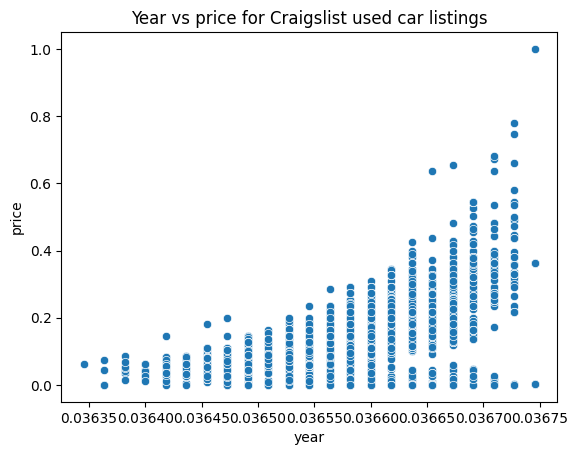

In [87]:
globalNormalizedData = (totalTransform@homogenizedData.T).T
print("after global normalization, globalNormalizedData")
print(getSummaryStatistics(globalNormalizedData))
print(getShapeType(globalNormalizedData))
plot2d(globalNormalizedData)

What seems weird to you about this process? What seems solid?

## Per-variable max-min normalization

Let's try **max-min normalization per variable**.

The transformation matrix for two variables, $x$ and $y$, looks like:
$$\begin{pmatrix} \frac{1}{(max(x)-min(x))} & 0 & -min(x) \\ 0 & \frac{1}{(max(y)-min(y))} & -min(y) \\ 0 & 0 & 1\end{pmatrix}$$

transformMatrix
((3, 3), dtype('float64'))
[[ 1.81818182e-05  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.54545455e-02 -9.08636364e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
after per variable normalization, localNormalizedData

[[0. 0. 1.]
 [1. 1. 1.]
 [0. 0. 1.]]
((3158, 3), dtype('float64'))


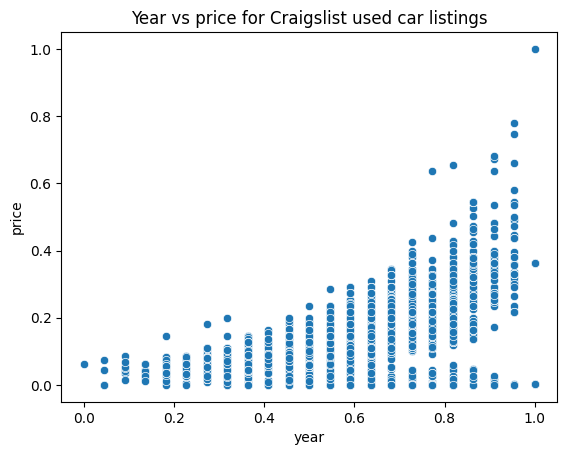

In [93]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
translateTransform[:, 2] = np.array([-homogenizedData[:, 0].min(), -homogenizedData[:, 1].min(), 1], dtype=int)
scaleTransform = np.eye(homogenizedData.shape[1]) * [1 / (homogenizedData[:, 0].max() - homogenizedData[:, 0].min()), 1 / (homogenizedData[:, 1].max() - homogenizedData[:, 1].min()), 1]

print("transformMatrix")
print(getShapeType(scaleTransform @ translateTransform))
print(scaleTransform @ translateTransform)


localNormalizedData = (scaleTransform @ translateTransform @homogenizedData.T).T
print("after per variable normalization, localNormalizedData")
print(getSummaryStatistics(localNormalizedData))
print(getShapeType(localNormalizedData))
plot2d(localNormalizedData)

What is good about this way of normalizing our data? What do we not like?

## Z-scoring

Max-min normalization will move everything to the unit square, but that may not help me see things more clearly. What if I try **z-scoring**: normalizing each feature by its mean and standard deviation instead?

The transformation matrix for two variables, $x$ and $y$, looks like:
$$\begin{pmatrix} \frac{1}{(std(x))} & 0 & -mean(x) \\ 0 & \frac{1}{(std(y))} & -mean(y) \\ 0 & 0 & 1\end{pmatrix}$$


transformMatrix
((3, 3), dtype('float64'))
[[ 1.80410758e-04  0.00000000e+00 -1.43936781e+00]
 [ 0.00000000e+00  2.50184647e-01 -5.03467052e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
after z-scoring, localNormalizedData

[[-1.43936781 -3.34794274  1.        ]
 [ 8.48322388  2.15611949  1.        ]
 [ 0.          0.          1.        ]]
((3158, 3), dtype('float64'))


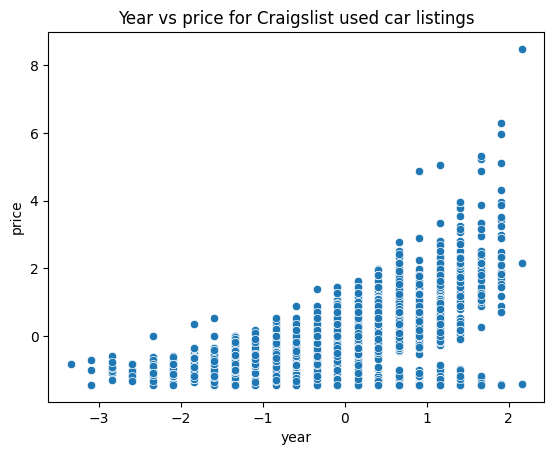

In [94]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
translateTransform[:, 2] = np.array([-homogenizedData[:, 0].mean(), -homogenizedData[:, 1].mean(), 1], dtype=float)
scaleTransform = np.eye(homogenizedData.shape[1]) * [1 / (homogenizedData[:, 0].std()), 1 / (homogenizedData[:, 1].std()), 1]

print("transformMatrix")
print(getShapeType(scaleTransform @ translateTransform))
print(scaleTransform @ translateTransform)


localNormalizedData = (scaleTransform @ translateTransform @homogenizedData.T).T
print("after z-scoring, localNormalizedData")
print(getSummaryStatistics(localNormalizedData))
print(getShapeType(localNormalizedData))
plot2d(localNormalizedData)

Let's **rotate** the data by 270 degrees, because I like things to go up to the right

In [ ]:
rotateTransform = 
print("transformMatrix")
print(getShapeType(rotateTransform))
print(rotateTransform)

rotatedData = 
print("after rotating, rotatedData")
print(getSummaryStatistics(rotatedData))
print(getShapeType(rotatedData))
sns.scatterplot(x="km", y="price", palette="colorblind", sizes=(40, 200) , alpha=.6, data=pd.DataFrame(rotatedData, columns=["price", "km", ""]))

What if I wanted to rotate it *and translate it to be centered on zero*?

Some resources:
* https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20162017/LectureNotes/MATH/homogenous.html
* https://primer-computational-mathematics.github.io/book/d_geosciences/remote_sensing/Image_Transformations_and_Orthorectification.html
* https://www.informit.com/articles/article.aspx?p=2854376&seqNum=8
* https://towardsdatascience.com/normalization-techniques-in-python-using-numpy-b998aa81d754
* https://www.machinecurve.com/index.php/2020/11/19/how-to-normalize-or-standardize-a-dataset-in-python/